In [ ]:
!pip install shap
!pip install sweetviz
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import math 
from sklearn.preprocessing import LabelEncoder
import shap
import sweetviz
import os
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
import pickle
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score,f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE

%matplotlib inline

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.


In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150

In [ ]:
#Reading the Dataset
new_data=pd.read_csv('/content/drive/MyDrive/Final Year project/loan-default-prediction/accepted_2007_to_2018Q4.csv',low_memory=False)

In [ ]:
new_data.shape

(2260701, 151)

In [ ]:
#Response/Target Variable 
new_data.loan_status.value_counts()

#Considering only Fully Paid, Default, Charged Off Loans.
resp=['Current']
Loan_Main = new_data[~new_data['loan_status'].isin(resp)] 
Loan_Main["loan_status"] = np.where(Loan_Main["loan_status"].str.contains("Fully"), 0, 1)

#New Dataset shape
Loan_Main.shape

# Changing employee length to numerical.
Loan_Main['emp_length'].fillna("< 1 year",inplace= True)
dict_emp_length = {'10+ years':10, '6 years':6, '4 years':4, '< 1 year':0.5, '2 years':2,'9 years':9, '5 years':5, '3 years':3, '7 years':7, '1 year':1,'8 years':8}
Loan_Main['emp_length'].replace(dict_emp_length, inplace=True)



#Seperating Loan_Main dataset into two based on Application_Type (Individual / Joint Type)
grouped = Loan_Main.groupby(Loan_Main.application_type)
Individual_Loan=grouped.get_group("Individual")
Joint_Loan=grouped.get_group("Joint App")

In [ ]:
Joint_Loan.shape

(29584, 151)

In [ ]:
Joint_Loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,...,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10.0,MORTGAGE,63000.00,Not Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.0,0.0,22705.924294,22705.92,20000.00,2705.92,0.0,0.00,0.0000,Jun-2017,15813.30,NaN,Mar-2019,704.0,700.0,0.0,NaN,1.0,Joint App,71000.00,13.85,Not Verified,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,...,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,NaN,10.0,NaN,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
438,68340637,NaN,15000.0,15000.0,15000.0,36 months,11.99,498.15,C,C1,Lead Tech,1.0,MORTGAGE,65000.00,Source Verified,Dec-2015,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,NaN,919xx,CA,17.56,0.0,Aug-2004,665.0,669.0,0.0,54.0,NaN,9.0,0.0,13028.0,88.3,16.0,w,0.0,0.0,15183.460000,15183.46,15000.00,183.46,0.0,0.00,0.0000,Feb-2016,15208.44,NaN,Feb-2016,769.0,765.0,0.0,NaN,1.0,Joint App,77000.00,15.40,Not Verified,0.0,0.0,231860.0,0.0,0.0,0.0,0.0,30.0,22525.0,74.0,0.0,2.0,2839.0,78.0,14800.0,...,1.0,2.0,2.0,25762.0,295.0,94.2,0.0,0.0,99.0,136.0,13.0,13.0,1.0,28.0,NaN,11.0,54.0,0.0,2.0,7.0,2.0,3.0,4.0,7.0,11.0,7.0,9.0,0.0,0.0,0.0,0.0,92.3,100.0,0.0,0.0,251645.0,35553.0,5100.0,30649.0,NaN,NaN,

In [ ]:
col=['purpose']
enc= LabelEncoder()
Joint_Loan.loc[:,col]= Joint_Loan.loc[:,col].apply(enc.fit_transform)

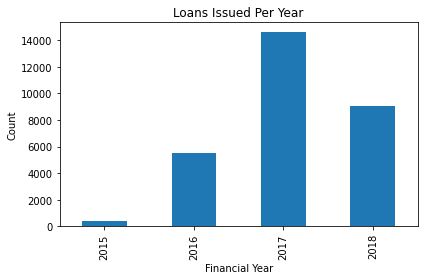

In [ ]:
Joint_Loan['issue_d'] = pd.to_datetime(Joint_Loan['issue_d'])

Joint_Loan['issue_d'].dt.year.value_counts().sort_index().plot.bar()
plt.title('Loans Issued Per Year')
plt.xlabel('Financial Year')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

In [ ]:
#set fraction
frac = 0.80
#get fractions and make deep copy
df_train = Joint_Loan.loc[Joint_Loan['issue_d']  < Joint_Loan['issue_d'].quantile(frac)]
df_test =  Joint_Loan.loc[Joint_Loan['issue_d'] >= Joint_Loan['issue_d'].quantile(frac)]

In [ ]:
#save as compressed zipped files to save space
df_test.to_csv('/content/drive/MyDrive/data/df_test_jl.csv.zip')
df_train.to_csv('/content/drive/MyDrive/data/df_train_jl.csv.zip')

In [ ]:
leak_cols = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 
             'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 
             'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 
             'initial_list_status', 'mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct','last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
             'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'sec_app_collections_12_mths_ex_med',
             'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 
             'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  
             'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq',     'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 
             'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'last_fico_range_high','last_fico_range_low','url','id','title','addr_state',
             'tot_hi_cred_lim','total_bal_ex_mort', 'total_bc_limit', 'sec_app_chargeoff_within_12_mths',
             'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 
             'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 
             'total_rev_hi_lim']
#drop leaks
df_small = df_train.drop(columns=leak_cols, axis=1)
drop_col_count = len(leak_cols)
print("The new dataframe has {} columns and lost {} after dropping future leaks".format(df_small.shape[1],
                                                                           drop_col_count))

The new dataframe has 84 columns and lost 67 after dropping future leaks


In [ ]:
df_small.shape

(22963, 84)

In [ ]:
#remove columns that have only 1 feature
#get unique values per feature
nunique_value = df_small.apply(pd.Series.nunique)
#note columns that have single value
single_value_cols = nunique_value[nunique_value == 1].index.tolist()
print(single_value_cols)

['policy_code', 'application_type', 'hardship_type', 'deferral_term', 'hardship_length']


In [ ]:
# drop the redundant columns
df_small = df_small.drop(columns=single_value_cols)

In [ ]:
#make dataframe to record mean missing
nan_df = pd.DataFrame(df_small.isna().mean(), columns=['mean_nan'])
#add dtypes
nan_df['dtypes'] = df_small.dtypes
#sort by most missing at top
nan_df = nan_df.sort_values(by=['mean_nan'], ascending=False)

nan_df = nan_df.reset_index()

nan_df.head()

,index,mean_nan,dtypes
0,member_id,1.000000,float64
1,desc,1.000000,object
2,orig_projected_additional_accrued_interest,0.988111,float64
3,hardship_last_payment_amount,0.983582,float64
4,hardship_payoff_balance_amount,0.983582,float64


In [ ]:
a=df_small.isnull().sum()/len(df_small)*100
variables = df_small.columns
variable = [ ]
for i in range(0,len(df_small.columns)):
    if a[i]<50:   #setting the threshold as 90% (MissingValue)
        variable.append(variables[i])
 # Dropping Columns based on missing data being more than 60% 
drop_columns1=list(set(variables) - set(variable))
df_drop_nan=df_small.drop(columns=drop_columns1)

In [ ]:
df_drop_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22963 entries, 2 to 2260663
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   loan_amnt                  22963 non-null  float64       
 1   term                       22963 non-null  object        
 2   int_rate                   22963 non-null  float64       
 3   installment                22963 non-null  float64       
 4   grade                      22963 non-null  object        
 5   sub_grade                  22963 non-null  object        
 6   emp_title                  19652 non-null  object        
 7   emp_length                 22963 non-null  float64       
 8   home_ownership             22963 non-null  object        
 9   annual_inc                 22963 non-null  float64       
 10  verification_status        22963 non-null  object        
 11  issue_d                    22963 non-null  datetime64[ns]
 12  lo

In [ ]:
import sweetviz
my_report = sweetviz.analyze([df_drop_nan.drop(columns='issue_d'), "Training Data"], target_feat= "loan_status")

                                             |          | [  0%]   00:00 -> (? left)

In [ ]:
my_report.show_html('/content/drive/MyDrive/data/Joint_Loan.html')

Report /content/drive/MyDrive/data/Joint_Loan.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
def df_object_to_num(df_obj):
    
    """Custom function to transform categorical features into numerical ones
    This function will also be applied on the testing data so that we apply the same exact kind of transformation
    """
    
    #make deep copy
    df_num = df_obj.copy()
    
    col_drop_list = ['emp_title']
    
    df_num['mort_acc'] = np.where(df_num['mort_acc'].isnull(), 0,df_num['mort_acc'])
    #pub_rec_bankruptcies
    df_num['pub_rec_bankruptcies'] = np.where(df_num['pub_rec_bankruptcies']>0, 1, 0)
    # pub_rec
    df_num['pub_rec'] = np.where(df_num['pub_rec']>0, 1, 0)
    
     ### instantiate dicts ### 
    term_to_int = {' 36 months': 1,
                   ' 60 months': 2}
    grade_to_int = dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G'], np.arange(7, 0, -1)))
    #copied from above, we can write a function to generate this dict
    sub_grade_sorted = {'G5': 0, 'G4': 1, 'G3': 2, 'G2': 3, 'G1': 4,
                        'F5': 5, 'F4': 6, 'F3': 7, 'F2': 8, 'F1': 9,
                        'E5': 10, 'E4': 11, 'E3': 12, 'E2': 13, 'E1': 14,
                        'D5': 15, 'D4': 16, 'D3': 17, 'D2': 18, 'D1': 19,
                        'C5': 20, 'C4': 21, 'C3': 22, 'C2': 23, 'C1': 24,
                        'B5': 25, 'B4': 26, 'B3': 27, 'B2': 28, 'B1': 29,
                        'A5': 30, 'A4': 31, 'A3': 32, 'A2': 33, 'A1': 34}    
    home_to_int = {'MORTGAGE': 4, 'RENT': 3, 'OWN': 5,'ANY': 2,'OTHER': 1, 'NONE':0 }
    ver_stat_to_int = {'Source Verified':2,'Verified': 1,'Not Verified': 0} 
    #replacements
    df_num['verification_status_joint'] = np.where(df_num['verification_status_joint'].isnull(), 'Not Verified',df_num['verification_status_joint'])

    df_num.replace({'term': term_to_int, 
                    'grade':grade_to_int,
                    'sub_grade': sub_grade_sorted,
                    'home_ownership':home_to_int,
                    'verification_status':ver_stat_to_int,
                   'verification_status_joint':ver_stat_to_int}, inplace=True)
    col_drop_list.append('zip_code')
    
    df_num['il_util'] = np.where(df_num['il_util'].isnull(),df_num['il_util'].mean() , df_num['il_util'])
    df_num['revol_util'] = np.where(df_num['revol_util'].isnull(),df_num['revol_util'].mean() , df_num['revol_util'])
    df_num['dti'] = np.where(df_num['dti'].isnull(),df_num['dti'].mean() , df_num['dti'])

    df_num['fico_avg_score'] = (df_num['fico_range_high']+df_num['fico_range_low'] )/2
    col_drop_list.extend(['fico_range_high','fico_range_low'])

    df_num['sec_fico_avg_score'] = (df_num['sec_app_fico_range_high']+df_num['sec_app_fico_range_low'] )/2
    col_drop_list.extend(['sec_app_fico_range_high','sec_app_fico_range_low'])
    
    df_num['earliest_cr_line']=  pd.to_datetime(df_num['earliest_cr_line'], infer_datetime_format=True)
    df_num['issue_d']=  pd.to_datetime(df_num['issue_d'], infer_datetime_format=True)
    credit_hist= df_num['issue_d'] - df_num['earliest_cr_line']
    df_num['credit_hist']=credit_hist.dt.days
    col_drop_list.append('earliest_cr_line')

    df_num['sec_app_earliest_cr_line']=  pd.to_datetime(df_num['sec_app_earliest_cr_line'], infer_datetime_format=True)
    df_num['issue_d']=  pd.to_datetime(df_num['issue_d'], infer_datetime_format=True)
    credit_hist= df_num['issue_d'] - df_num['sec_app_earliest_cr_line']
    df_num['sec_credit_hist']=credit_hist.dt.days
    col_drop_list.append('sec_app_earliest_cr_line')
    col_drop_list.append('issue_d')
    
   

    #Balance_annual_income
    df_num['balance_annual_inc'] = np.where(df_num['annual_inc']==0,0 , df_num['loan_amnt'] / df_num['annual_inc'])
    
    #Balance_annual_income
    df_num['sec_balance_annual_inc'] = np.where(df_num['annual_inc_joint']==0,0 , df_num['loan_amnt'] / df_num['annual_inc_joint'])
    
    df_num['annual_inc']+=1
    df_num['annual_inc_joint']+=1
    df_num['annual_inc']=np.log(df_num['annual_inc'])
    df_num['total_bal_il']+=1
    df_num['total_bal_il']=np.log(df_num['total_bal_il'])
    df_num['revol_bal']+=1
    df_num['revol_bal']=np.log(df_num['revol_bal'])
    df_num['revol_bal_joint']+=1
    df_num['revol_bal_joint']=np.log(df_num['revol_bal_joint'])
    df_num['annual_inc_joint']=np.log(df_num['annual_inc_joint'])
    df_num['max_bal_bc']+=1
    df_num['max_bal_bc']=np.log(df_num['max_bal_bc'])
    
    df_num['inst_amnt_ratio']=df_num['installment']/df_num['loan_amnt']
    col_drop_list.extend(['installment','loan_amnt'])
    
     # credit_line_ratio 
    df_num['credit_line_ratio']=df_num['open_acc']/df_num['total_acc']
    col_drop_list.extend(['open_acc','total_acc'])
    
    df_num  = df_num.drop(columns=col_drop_list)
    df_num=df_num.dropna()

    return df_num
    

In [ ]:
#make entries numerical
df_num = df_object_to_num(df_drop_nan)
df_num.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,pub_rec,revol_bal,revol_util,annual_inc_joint,dti_joint,verification_status_joint,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,mort_acc,pub_rec_bankruptcies,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,fico_avg_score,sec_fico_avg_score,credit_hist,sec_credit_hist,balance_annual_inc,sec_balance_annual_inc,inst_amnt_ratio,credit_line_ratio
459321,1,10.91,6,26,10.0,4,11.225257,1,0,2,38.240000,0,9.832689,59.5,11.782960,25.23,1,0.0,5.0,1.0,2.0,12.0,12.161630,67.0,2.0,2.0,8.636930,64.0,0.0,1.0,1.0,1.0,0,10.778143,0.0,1.0,6.0,49.3,3.0,9.0,717.0,612.0,5054,7489.0,0.160000,0.091603,0.032697,0.323529
459376,1,30.75,2,5,10.0,4,11.350418,1,1,2,16.070000,1,8.909641,31.4,11.487618,14.31,1,4.0,3.0,2.0,2.0,2.0,10.523903,99.0,3.0,3.0,8.421343,73.0,2.0,1.0,7.0,3.0,0,9.944582,1.0,0.0,6.0,31.5,1.0,7.0,697.0,577.0,4689,2254.0,0.401471,0.350000,0.042864,0.769231
459384,1,16.02,5,20,10.0,4,11.018646,1,0,2,7.630000,1,8.386173,31.3,11.669938,3.98,1,1.0,1.0,1.0,1.0,9.0,8.725670,77.0,2.0,2.0,7.575585,48.0,0.0,2.0,1.0,1.0,1,9.263312,0.0,1.0,3.0,88.5,0.0,3.0,692.0,657.0,8189,5451.0,0.102049,0.053205,0.035168,0.636364
459431,2,19.42,4,17,0.5,4,0.000000,0,0,2,32.176832,0,8.768885,50.2,11.512935,9.00,0,0.0,0.0,1.0,1.0,8.0,9.494165,81.0,1.0,1.0,8.586906,67.0,0.0,0.0,2.0,0.0,0,9.199987,2.0,0.0,8.0,58.2,0.0,7.0,717.0,667.0,3045,5329.0,0.000000,0.144000,0.026172,0.714286
459617,2,20.39,4,16,1.0,3,11.407576,0,1,1,43.110000,0,10.930854,94.1,12.022018,32.96,0,0.0,5.0,1.0,3.0,8.0,11.444122,44.0,0.0,2.0,9.493412,67.0,2.0,1.0,11.0,2.0,0,11.465173,1.0,2.0,18.0,75.1,4.0,22.0,682.0,672.0,8738,8677.0,0.266667,0.144251,0.026712,0.500000


In [ ]:
#drop leak columns
df_test = df_test.drop(columns=leak_cols, axis=1)

# drop the redundant columns
df_test = df_test.drop(columns=single_value_cols)

#drop the columns
df_test = df_test.drop(columns=drop_columns1)

In [ ]:
#make numerical
df_test_num = df_object_to_num(df_test)

In [ ]:
#save as compressed zipped files to save space
df_num.to_csv('/content/drive/MyDrive/data/df_train_jl_scale.csv')

In [ ]:
ss = StandardScaler()
df_train_num=df_num.copy()

target_col = 'loan_status'

#feature space
X_train = df_train_num.drop(columns=[target_col])
X_test = df_test_num.drop(columns=[target_col])

#target variable
y_train = df_train_num[target_col]
y_test = df_test_num[target_col]


X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [ ]:
#ROC dict for TPR and FPR values
roc_dict = {}

#precision recall curve
prc_dict = {}


def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for ROC metrics
    """
    
    fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    
    clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds}
    
    dict_modify[name] = clf_roc_dict
    
def modify_prc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for precision recall metrics
    """
    
    precision, recall, thresholds = precision_recall_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    clf_prc_dict = {'precision':precision, 'recall': recall, 'thresholds': thresholds}
    
    dict_modify[name] = clf_prc_dict

In [ ]:
def fit_score_clf(clf, X_train, y_train, X_test, y_test, name='clf'):
    """
    fits a classifer from sklearn and returns a dataframe
    clf(sklearn): classifier
    X_train(numpy): train features
    y_train(numpy): predictions row vector
    X_test(numpy): test features
    y_test(numpy): ground truth row vector
    name(string): name of classifier
    
    """
    #fit to train data
    clf.fit(X_train, y_train)
    #make predictions
    y_pred = clf.predict(X_test)
    #make dataframe from report
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    #add clf name as column
    clf_report['clf'] = name
    
    return clf_report

In [ ]:
#instantiate with default params
lr  = LogisticRegression(penalty='l2',
                         C=1.0,
                         solver = 'lbfgs',
                         max_iter=400,
                         n_jobs=-1)

lr_report = fit_score_clf(lr, X_train, y_train, X_test, y_test, name='lr')
lr_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.679851,0.592035,0.663941,0.635943,0.647411,lr
recall,0.882787,0.290365,0.663941,0.586576,0.663941,lr
f1-score,0.768142,0.389633,0.663941,0.578887,0.628317,lr
support,3933.000000,2304.000000,0.663941,6237.000000,6237.000000,lr


In [ ]:
#metrics for lr
modify_roc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression', 
                dict_modify=roc_dict)
modify_prc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression',
                dict_modify=prc_dict)

In [ ]:
gbtree = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 100)

gbtree_report = fit_score_clf(gbtree, X_train, y_train, X_test, y_test, name='gbtree')
gbtree_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.695100,0.641304,0.684784,0.668202,0.675228,gbtree
recall,0.890923,0.332899,0.684784,0.611911,0.684784,gbtree
f1-score,0.780923,0.438286,0.684784,0.609604,0.654350,gbtree
support,3933.000000,2304.000000,0.684784,6237.000000,6237.000000,gbtree


In [ ]:
#metrics for gbtree
modify_roc_dict(gbtree, y_test, X_test, name='GBTree',dict_modify=roc_dict)

In [ ]:
modify_prc_dict(clf=gbtree,
                y_test=y_test,
                X_test=X_test,
                name='GBTree',
                dict_modify=prc_dict)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

rf_report = fit_score_clf(rf, X_train, y_train, X_test, y_test, name='rf')
rf_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.681704,0.615672,0.670354,0.648688,0.657311,rf
recall,0.895245,0.286458,0.670354,0.590852,0.670354,rf
f1-score,0.774016,0.390995,0.670354,0.582506,0.632525,rf
support,3933.000000,2304.000000,0.670354,6237.000000,6237.000000,rf


In [ ]:
#metrics for random forest
modify_roc_dict(rf, y_test, X_test, name='RandomForest',dict_modify=roc_dict)

In [ ]:
modify_prc_dict(clf=rf,
                y_test=y_test,
                X_test=X_test,
                name='RandomForest',
                dict_modify=prc_dict)

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=300,
                            subsample=0.9,
                            n_jobs=-1)

xgb_report = fit_score_clf(xgb_clf, X_train, y_train, X_test, y_test, name='xgb')
xgb_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.701344,0.631698,0.686548,0.666521,0.675616,xgb
recall,0.875922,0.363281,0.686548,0.619601,0.686548,xgb
f1-score,0.778971,0.461284,0.686548,0.620128,0.661615,xgb
support,3933.000000,2304.000000,0.686548,6237.000000,6237.000000,xgb


In [ ]:
#metrics for svc
modify_roc_dict(xgb_clf, y_test, X_test, name='XGBoost',dict_modify=roc_dict)

In [ ]:
modify_prc_dict(clf=xgb_clf,
                y_test=y_test,
                X_test=X_test,
                name='XGBoost',
                dict_modify=prc_dict)

In [ ]:
#put hard limit on iterations to save time in exploration phase
svc = SVC(C=1.0, kernel='rbf',
          gamma='auto', 
          probability=True,
          max_iter=400)

svc_report = fit_score_clf(svc, X_train, y_train, X_test, y_test, name='svc')
svc_report.head()

Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.648013,0.376404,0.454225,0.512209,0.547679,svc
recall,0.294432,0.726997,0.454225,0.510714,0.454225,svc
f1-score,0.404895,0.496002,0.454225,0.450449,0.438551,svc
support,3933.000000,2304.000000,0.454225,6237.000000,6237.000000,svc


In [ ]:
#metrics for svc
modify_roc_dict(svc, y_test, X_test, name='SVC',dict_modify=roc_dict)

In [ ]:
modify_prc_dict(clf=svc,
                y_test=y_test,
                X_test=X_test,
                name='SVC',
                dict_modify=prc_dict)

In [ ]:
knn = KNeighborsClassifier(n_neighbors =5, n_jobs=-1)

knn_report = fit_score_clf(knn, X_train, y_train, X_test, y_test, name='KNN')
knn_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.650161,0.427481,0.594036,0.538821,0.567901,KNN
recall,0.771167,0.291667,0.594036,0.531417,0.594036,KNN
f1-score,0.705513,0.346749,0.594036,0.526131,0.572983,KNN
support,3933.000000,2304.000000,0.594036,6237.000000,6237.000000,KNN


In [ ]:
#metrics for knn
modify_roc_dict(knn, y_test, X_test, name='KNN',dict_modify=roc_dict)

In [ ]:
modify_prc_dict(clf=knn,
                y_test=y_test,
                X_test=X_test,
                name='knn',
                dict_modify=prc_dict)

In [ ]:
#see keys we have
roc_dict.keys()

dict_keys(['Logistic Regression', 'GBTree', 'RandomForest', 'XGBoost', 'SVC', 'KNN'])

FileNotFoundError: ignored

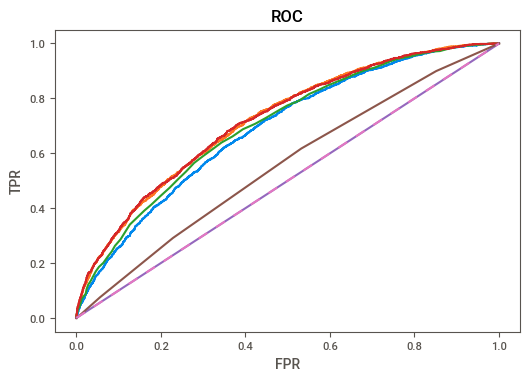

In [ ]:
for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.savefig(os.path.join('/content/drive/MyDrive/plots/roc_curve_all_models.png'))
plt.legend()
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


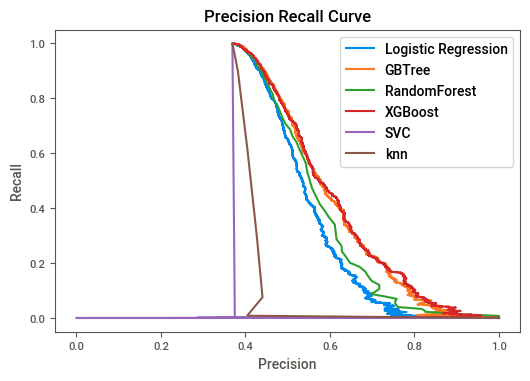

In [ ]:
for key in prc_dict:
    clf = prc_dict[key]
    plt.plot(clf['precision'], clf['recall'], label=key)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.savefig(os.path.join('/content/drive/MyDrive/plots/prc_curve_all_models.png'))

plt.legend()

plt.show()

In [ ]:
gbtree.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[3445,  488],
       [1467,  837]])

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,gbtree.predict_proba(X_test)[:,1],pos_label=1)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       gbtree.predict_proba(X_test)[:,1],
                                                       pos_label=1)

In [ ]:
gb_auc = roc_auc_score(y_test, gbtree.predict_proba(X_test)[:,1])
print("gb_auc: {}".format(gb_auc))

gb_auc: 0.7200581528801876


In [ ]:
X_test.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,pub_rec,revol_bal,revol_util,annual_inc_joint,dti_joint,verification_status_joint,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,mort_acc,pub_rec_bankruptcies,revol_bal_joint,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,fico_avg_score,sec_fico_avg_score,credit_hist,sec_credit_hist,balance_annual_inc,sec_balance_annual_inc,inst_amnt_ratio,credit_line_ratio
421212,2,14.07,5,22,3.0,4,10.463132,1,2,53.03,1,9.609452,60.3,11.482477,21.04,1,3.0,3.0,2.0,3.0,3.0,10.905662,88.0,1.0,1.0,5.293305,80.0,2.0,3.0,3.0,2.0,1,10.067815,3.0,3.0,9.0,63.1,3.0,6.0,682.0,677.0,4230,6909,0.714286,0.257732,0.023305,0.444444
421222,1,17.47,4,19,2.0,3,10.839601,1,1,10.56,1,1.098612,0.1,11.711785,7.47,1,1.0,3.0,0.0,1.0,17.0,10.030384,95.0,2.0,2.0,1.098612,86.0,4.0,0.0,2.0,0.0,0,7.156956,5.0,1.0,13.0,32.0,9.0,12.0,707.0,637.0,3652,4046,0.019608,0.008197,0.035890,0.555556
421291,2,30.65,2,6,4.0,4,10.714440,1,1,43.63,1,9.522227,56.9,11.884496,32.01,1,0.0,9.0,1.0,3.0,8.0,11.212509,102.0,0.0,1.0,7.788626,85.0,1.0,1.0,1.0,1.0,1,11.406030,0.0,3.0,17.0,68.5,5.0,13.0,687.0,672.0,3407,3468,0.444444,0.137931,0.032754,0.857143
421307,1,20.39,4,16,2.0,3,10.341775,0,3,20.79,0,0.000000,0.0,11.643962,21.61,0,0.0,7.0,1.0,3.0,8.0,10.587291,97.0,0.0,1.0,0.000000,93.0,1.0,0.0,3.0,0.0,0,8.526945,3.0,0.0,9.0,82.8,4.0,5.0,707.0,632.0,2130,4230,0.193548,0.052632,0.037363,1.000000
421324,1,19.42,4,17,7.0,4,10.714440,2,2,62.70,0,10.674105,45.0,12.460719,30.04,2,0.0,6.0,0.0,0.0,57.0,11.943941,65.0,0.0,0.0,9.483340,48.0,0.0,0.0,0.0,0.0,0,11.774012,3.0,4.0,20.0,65.1,7.0,18.0,697.0,687.0,5569,7183,0.805556,0.140504,0.036869,0.562500


In [ ]:
#define location to save trained model
save_model_dir = os.path.join('/content/drive/MyDrive/Models/gb_default_params_joint.pickle')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(xgb_clf,
                handle,
                protocol=pickle.HIGHEST_PROTOCOL)

Saving model at: /content/drive/MyDrive/Models/gb_default_params_joint.pickle


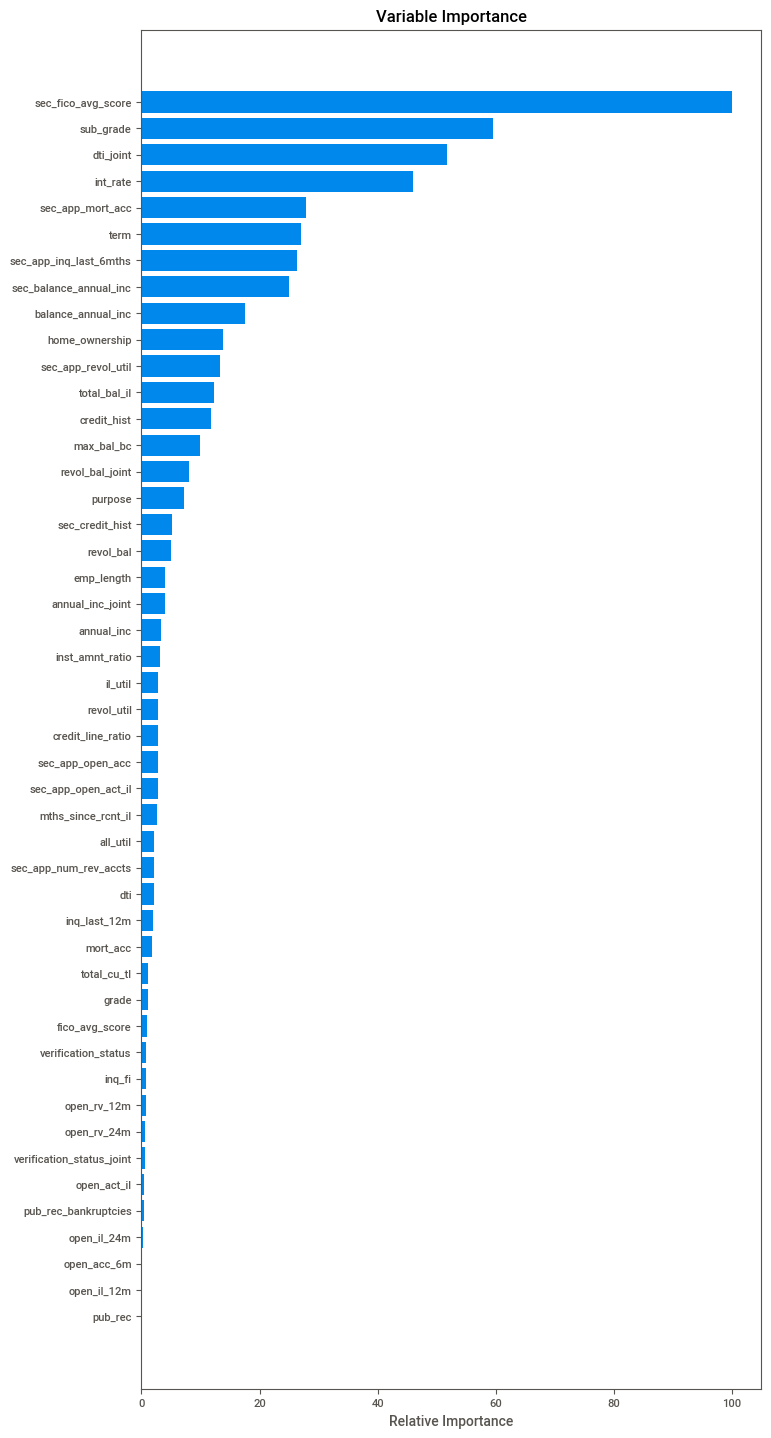

In [ ]:
feature_importance = gbtree.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()



In [ ]:
 X_train.keys()[sorted_idx]

Index(['pub_rec', 'open_il_12m', 'open_acc_6m', 'open_il_24m',
       'pub_rec_bankruptcies', 'open_act_il', 'verification_status_joint',
       'open_rv_24m', 'open_rv_12m', 'inq_fi', 'verification_status',
       'fico_avg_score', 'grade', 'total_cu_tl', 'mort_acc', 'inq_last_12m',
       'dti', 'sec_app_num_rev_accts', 'all_util', 'mths_since_rcnt_il',
       'sec_app_open_act_il', 'sec_app_open_acc', 'credit_line_ratio',
       'revol_util', 'il_util', 'inst_amnt_ratio', 'annual_inc',
       'annual_inc_joint', 'emp_length', 'revol_bal', 'sec_credit_hist',
       'purpose', 'revol_bal_joint', 'max_bal_bc', 'credit_hist',
       'total_bal_il', 'sec_app_revol_util', 'home_ownership',
       'balance_annual_inc', 'sec_balance_annual_inc',
       'sec_app_inq_last_6mths', 'term', 'sec_app_mort_acc', 'int_rate',
       'dti_joint', 'sub_grade', 'sec_fico_avg_score'],
      dtype='object')

In [ ]:
keep_columns=['credit_hist', 'total_bal_il',
       'home_ownership', 'balance_annual_inc', 'sec_app_revol_util',
       'sec_balance_annual_inc', 'term', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'dti_joint', 'sec_fico_avg_score', 'sub_grade']
select_X_train=X_train[keep_columns]
select_X_test=X_test[keep_columns]

In [ ]:
#define the param grid
# Parameters of pipelines can be set using ‘__’ separated para
clf_grid = {
    "gbtree__max_depth":[3,5,8],
    'gbtree__learning_rate': [0.01,0.05,0.1],
    'gbtree__n_estimators' : [100,500,1000],
    }

#define the pipeline
model_pipe = Pipeline([('gbtree', GradientBoostingClassifier())])

#define the classifer
clf = GridSearchCV(model_pipe,
                   clf_grid,
                   n_jobs=-1,
                   cv=4, 
                   verbose=50, 
                   scoring='roc_auc')


#fit to training data
clf.fit(select_X_train, y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('gbtree',
                                        GradientBoostingClassifier(ccp_alpha=0.0,
                                                                   criterion='friedman_mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='deviance',
                                                                   max_depth=3,
                                                                   max_features=None,
                                                                   max_leaf_nodes=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
      

In [ ]:
print("Best model parameters: \n")
print(clf.best_params_ )
print("Best model score: \n")
print(clf.best_score_)

Best model parameters: 

{'gbtree__learning_rate': 0.01, 'gbtree__max_depth': 3, 'gbtree__n_estimators': 1000}
Best model score: 

0.7250390380261389


In [ ]:
y_pred = clf.predict(select_X_test)
confusion_matrix(y_test, y_pred)


array([[3501,  432],
       [1552,  752]])

In [ ]:
f1_gb = f1_score(y_test, y_pred)

print("f1_gb (binary): {}\n".format(f1_gb))
print(classification_report(y_test,y_pred))

f1_gb (binary): 0.43119266055045874

              precision    recall  f1-score   support

           0       0.69      0.89      0.78      3933
           1       0.64      0.33      0.43      2304

    accuracy                           0.68      6237
   macro avg       0.66      0.61      0.61      6237
weighted avg       0.67      0.68      0.65      6237



In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,
                                 clf.predict_proba(select_X_test)[:,1],
                                 pos_label=1)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       clf.predict_proba(select_X_test)[:,1],
                                                       pos_label=1)

In [ ]:
gb_auc = roc_auc_score(y_test, clf.predict_proba(select_X_test)[:,1])
print("gb_auc: {}".format(gb_auc)) 

gb_auc: 0.7088269530256802


In [ ]:
#define location to save trained model
save_model_dir = os.path.join('/content/drive/MyDrive/Models','gb_cv_compact_joint.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(clf,
                handle)

Saving model at: /content/drive/MyDrive/Models/gb_cv_compact_joint.pkl


In [ ]:
select_X_train=X_train[keep_columns].values
select_X_test=X_test[keep_columns].values

In [ ]:
y_train=y_train.values

In [ ]:
from tqdm import tqdm

auc_arr = []
for _ in tqdm(range(100)):
    idx = np.random.choice(np.arange(len(select_X_train)), 8000, replace=True)
    X_temp = select_X_train[idx]
    y_temp = y_train[idx]
        vd
    #instantiate classifier
    clf=GradientBoostingClassifier(learning_rate=0.01, n_estimators = 1000,max_depth=3)
    #fit to new data
    clf.fit(X_temp, y_temp)
    
    #predictions and scoring
    score = roc_auc_score(y_test, clf.predict_proba(select_X_test)[:,1])
    auc_arr.append(score)

100%|██████████| 100/100 [30:29<00:00, 18.29s/it]


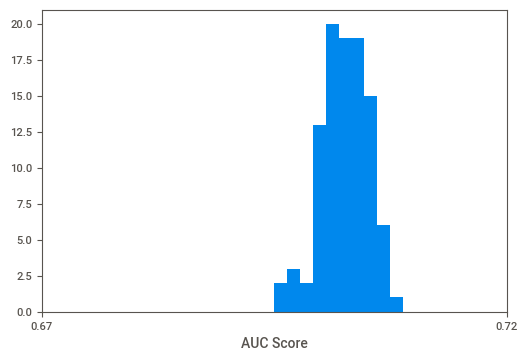

In [ ]:
plt.hist(auc_arr)
plt.xlabel("AUC Score")
plt.xticks(np.arange(0.67, 0.77, 0.05))
plt.savefig(os.path.join("/content/drive/MyDrive/plots", 'auc_632_sampling_joint.png'))
plt.show()